<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-and-settings" data-toc-modified-id="Import-and-settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import and settings</a></span></li><li><span><a href="#Prepare-test-set" data-toc-modified-id="Prepare-test-set-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Prepare test set</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Evaluation</a></span><ul class="toc-item"><li><span><a href="#ROIs-per-patient-metrics" data-toc-modified-id="ROIs-per-patient-metrics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>ROIs per-patient metrics</a></span></li><li><span><a href="#WSIs-per-patient-metrics" data-toc-modified-id="WSIs-per-patient-metrics-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>WSIs per-patient metrics</a></span><ul class="toc-item"><li><span><a href="#Load-crops-object-for-WSIs-evaluation" data-toc-modified-id="Load-crops-object-for-WSIs-evaluation-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Load crops object for WSIs evaluation</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Evaluate</a></span></li><li><span><a href="#WSIs-visualize" data-toc-modified-id="WSIs-visualize-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>WSIs visualize</a></span></li></ul></li><li><span><a href="#Leaf-without-root" data-toc-modified-id="Leaf-without-root-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Leaf without root</a></span></li></ul></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Comparison</a></span><ul class="toc-item"><li><span><a href="#Predict" data-toc-modified-id="Predict-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predict</a></span></li><li><span><a href="#Load-crop-objs" data-toc-modified-id="Load-crop-objs-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Load crop objs</a></span></li><li><span><a href="#Evaluate" data-toc-modified-id="Evaluate-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Evaluate</a></span></li></ul></li></ul></div>

# Import and settings
Run TreeCNN_Test.py to obtain list of elaborated crop objects

In [1]:
import os
import cv2
import math
import pickle
import itertools 
import openslide
import numpy as np
import pandas as pd
from utils import *
import seaborn as sns
# from vgg16 import Vgg16
# import tensorflow as tf
from _treecnn_utils import *
import matplotlib.pyplot as plt
from wsi_manager import CropList
from matplotlib import cm as plt_cmap
from make_heatmaps import make_heatmap
from wsi_manager import SectionManager
from make_heatmaps import _is_background
from make_heatmaps import _batch_iterator
from sklearn.metrics import confusion_matrix, f1_score
# Disable jedi autocompleter
%config Completer.use_jedi = False

# os.environ["CUDA_VISIBLE_DEVICES"] = '0'
# os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = 'true'

FONTSIZE = 16
rootdir = "/space/ponzio/Morpheme_v2/"
rootdir_output = "/space/ponzio/Morpheme_v2/results_classification/Pruning"
rootdir_wsi = os.path.join(rootdir, "data/RCC_WSIs")
if not os.path.exists(rootdir_output):
    os.makedirs(rootdir_output)

# Prepare test set

In [2]:
#---------------------------------------------------------------------------------------------------------------
# Load whole test dataframe
# NaiveDT
# df_test = pd.read_csv("/space/ponzio/Morpheme_v2/data/RandomTree_cc+chr-ONCO+pap_dfs/df-test-whole.csv")
# DRCCTree
df_test = pd.read_csv("/space/ponzio/Morpheme_v2/data/TreeCNN_Final_DFs_2-folds/df-test-whole.csv")
# RandomTree_cc+CHROMO-ONCO+pRCC
# df_test = pd.read_csv("/space/ponzio/Morpheme_v2/data/RandomTree_cc+CHROMO-ONCO+pRCC_dfs/df-test-whole.csv")
# RandomTree_cc+ONCO-CHROMO+pRCC
# df_test = pd.read_csv("/space/ponzio/Morpheme_v2/data/RandomTree_cc+ONCO-CHROMO+pRCC_dfs/df-test-whole.csv")
#---------------------------------------------------------------------------------------------------------------
print("Patients in ROIs test dataset")
print(pd.pivot_table(df_test, values="Patient", index="CancerType", aggfunc=pd.Series.nunique))

patients_test_unique = df_test['Patient'].unique()
patients_test_unique_id = [''.join(p.split('.')[0:2]) for p in patients_test_unique]

# The following patients are not present in ROIs dataset (only WSIs avaiable)
# Possible further patents must be added here
patients_not_in_ROIs = [
    "HP195524",
    "HP1213588",
    "HP19008963",
    "HP131799",
    "HP193695",
    "HP145590",
    "HP123187",
    "HP197949",
    "HP51171",
    "HP70605",
#     "HP1410122" # Training patient for images in thesis/paper
]

patients_test_unique_id += patients_not_in_ROIs
# Look for test patients in WSIs rootdir
# Get all WSIs' filepaths
filepaths_wsi = [os.path.join(dp, f) for dp, dn, filenames in os.walk(rootdir_wsi) for f in filenames if 
                 os.path.basename(f).split('.')[-1] == 'scn' 
                 or os.path.basename(f).split('.')[-1] == 'svs' 
                 or os.path.basename(f).split('.')[-1] == 'tif']
# filepaths_wsi = [path for path in filepaths_wsi if "not-in" not in path]
filepaths_wsi_not_in = [path for path in filepaths_wsi if "not-in" in path]

# Get Patients ID from WSIs
patient_wsi_ids = [''.join(os.path.basename(f).split('.')[0:2]) for f in filepaths_wsi]

# Get test patients WSIs
# N.B. Some patients have more than 1 wsi
# Label can be obtained from filepath
# '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/pRCC/HP09.5392.A16.pRCC.scn' --> Label: pRCC
filepaths_wsi_test = list()
labels_wsi = list()
# Dict to map univocal patient in wsi to univocal patient in test set. Note that some patients have more than one wsi.
patient_wsi2test = dict()
for patient in patients_test_unique_id:
    for patient_wsi_id, filepath_wsi in zip(patient_wsi_ids, filepaths_wsi):
        if patient in patient_wsi_id:
            patient_wsi2test[patient_wsi_id] = patient
            filepaths_wsi_test.append(filepath_wsi)
            labels_wsi.append(filepath_wsi.split(os.sep)[-2])
            
print("\n{} further patients (only WSIs):".format(len(patients_not_in_ROIs)))
for patient in np.unique(patients_not_in_ROIs):
    for patient_wsi_id, filepath_wsi in zip(patient_wsi_ids, filepaths_wsi):
        if patient in patient_wsi_id:
            print(patient, filepath_wsi.split(os.sep)[-2])
            break
print("\n{} patients in total".format(len((patients_test_unique_id))))
df = pd.DataFrame(patients_test_unique_id, columns=["Patient"], index=None)
# df.to_excel(os.path.join(rootdir_output, "test_patients.xlsx"))

df = pd.DataFrame(filepaths_wsi_test, columns=["WSI test id"], index=None)
# df.to_excel(os.path.join(rootdir_output, "test_wsi.xlsx"))

Patients in ROIs test dataset
            Patient
CancerType         
CHROMO            2
ONCO              2
ccRCC            16
pRCC              7

10 further patients (only WSIs):
HP1213588 ccRCC
HP123187 ccRCC
HP131799 ccRCC
HP145590 ccRCC
HP19008963 ONCOCYTOMA
HP193695 ccRCC
HP195524 ccRCC
HP197949 ccRCC
HP51171 ONCOCYTOMA
HP70605 CHROMO

37 patients in total


In [ ]:
df_test_unique_patients = df_test.drop_duplicates(subset=['Patient'])

# Evaluation

## ROIs per-patient metrics 

In [ ]:
# df_test_duplicated = pd.read_csv((os.path.join(rootdir_output, "df_predictions_ROIs.csv")), index_col=0, low_memory=False)
# df_test_cancer = df_test_duplicated[df_test_duplicated['CancerBinary-predictions'] == 'cancer']
# leaf1_coherent = [leaf in node for leaf, node in zip(df_test_cancer['Leaf1-predictions'], df_test_cancer['Node-predictions'])]
# leaf2_coherent = [leaf in node for leaf, node in zip(df_test_cancer['Leaf2-predictions'], df_test_cancer['Node-predictions'])]
# preds_leaf1 = df_test_cancer['Leaf1-predictions'][leaf1_coherent]
# preds_leaf2 = df_test_cancer['Leaf2-predictions'][leaf2_coherent]
# preds_and_patient_leaf1 = df_test_cancer[['Leaf1-predictions', 'Patient']][leaf1_coherent]
# preds_and_patient_leaf2 = df_test_cancer[['Leaf2-predictions', 'Patient']][leaf2_coherent]


# # Crop-wise 
# y_true_leaf1 = df_test_cancer['NotCancerAllTumors'][leaf1_coherent]
# y_true_leaf2 = df_test_cancer['NotCancerAllTumors'][leaf2_coherent]
# y_pred = np.hstack((preds_leaf1.values, preds_leaf2.values))
# y_true = np.hstack((y_true_leaf1.values, y_true_leaf2.values))
# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_pred)))
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# seaborn_cm(cm, ax, sorted(np.unique(y_pred)), fontsize=FONTSIZE)
# plt.tight_layout()
# filename_cm = f"TreeCNN (ROIs)\nImage-wise"
# fig.savefig(os.path.join(rootdir_output, filename_cm))

# # Patient-wise
# y_true = list()
# y_pred = list()
# for patient in df_test_duplicated.Patient.unique():
#     df_by_patient = df_test_duplicated[df_test_duplicated.Patient == patient]    
#     y_true.append(df_by_patient['CancerType'].value_counts().idxmax())
#     preds_leaf_1_by_patient = preds_and_patient_leaf1['Leaf1-predictions'][preds_and_patient_leaf1['Patient'] == patient]
#     preds_leaf_2_by_patient = preds_and_patient_leaf2['Leaf2-predictions'][preds_and_patient_leaf2['Patient'] == patient]
#     statistics = pd.concat([preds_leaf_1_by_patient.value_counts(), 
#                             preds_leaf_2_by_patient.value_counts()])
#     y_pred.append(statistics.idxmax())

# # Confusion matrix
# cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_pred)))
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# seaborn_cm(cm, ax, sorted(np.unique(y_pred)), fontsize=FONTSIZE)
# plt.tight_layout()
# filename_cm = f"TreeCNN (ROIs)\nPatient-wise"
# fig.savefig(os.path.join(rootdir_output, filename_cm))

## WSIs per-patient metrics 

### Load crops object for WSIs evaluation

In [3]:
#---------------------------------------------------------------------------------------------------------------
# NaiveDT
# filepath = "/space/ponzio/Morpheme_v2/results_classification/NaiveDT/crops.pickle"
# DRCCTree
# filepath = "/space/ponzio/Morpheme_v2/results_classification/28-01-2022/DRCCTree/WSIs_test_last/crops_objs_final/test_set_crops_17-04-2021.pickle"
filepath = "/space/ponzio/Morpheme_v2/results_classification/ExperDt_again_to_check/crops.pickle"
# RandomTree_cc+CHROMO-ONCO+pRCC
# filepath = "/space/ponzio/Morpheme_v2/results_classification/28-01-2022/RandomTree_cc+CHROMO-ONCO+pRCC_results/crops.pickle"
# RandomTree_cc+ONCO-CHROMO+pRCC
# filepath = "/space/ponzio/Morpheme_v2/results_classification/28-01-2022/RandomTree_cc+ONCO-CHROMO+pRCC_results/crops.pickle"
#---------------------------------------------------------------------------------------------------------------
with open(filepath, "rb") as handle:
    crop_obj_list = pickle.load(handle)
# crop_obj_list = crops_obj_list_tmp

### Evaluate
By changing parameters different settings may be tested

Optimal configuration
    
    refine = True, True, True
    leaf_given_node_by_patient_forced=False
    leaf_given_cancer=True if Node prediction is not sure(i.e. same # of crops classified in cc+p and C+O)

N.B.

Set `If Node prediction is not sure, pred is done again based on tumor mask` depending on DRCCTree verision

/space/ponzio/Morpheme_v2/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


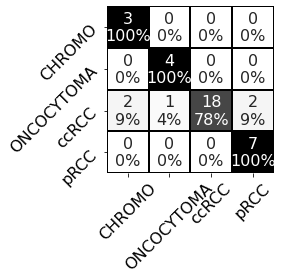

In [41]:
SIZE = (3, 3)
for permutation in list(itertools.product([True, False], repeat=3)):
    permutation = (True, True, True)
    permutation_cpy = permutation
    crops_dist_x = list()
    crops_dist_y = list()
    y_true = list()
    y_pred = list()
    y_patient = list()
    y_true_wsi = list()
    y_pred_wsi = list()
    y_pred_by_patch = list()
    y_true_by_patch = list()
    stats_by_patient = dict()
    for crop_obj in crop_obj_list:
        slide = openslide.OpenSlide(crop_obj.indexes[0]['filepath_slide'])
        patient_wsi_id = ''.join(os.path.basename(crop_obj.indexes[0]['filepath_slide']).split('.')[0:2])
        p, t, leaves_counter = predict_by_mask(slide, crop_obj, 
                                               size=SIZE, 
                                               selective_refine=permutation, 
                                               leaf_given_node_by_patient_forced=False)
        # Note that some patients corresondo to more then one WSI >>>>
        patient_id = patient_wsi2test[patient_wsi_id]
        # -----------------------------------------------------------------------
        # If Node prediction is not sure, pred is done again based on tumor mask
        if abs((leaves_counter['ccRCC'] + leaves_counter['pRCC']) - (leaves_counter['CHROMO'] + leaves_counter['ONCO'])) / sum(leaves_counter.values()) < 0.3:
        # # if abs((leaves_counter['ccRCC'] + leaves_counter['ONCO']) - (leaves_counter['CHROMO'] + leaves_counter['pRCC'])) / sum(leaves_counter.values()) < 0.3:
        # # if abs((leaves_counter['ccRCC'] + leaves_counter['CHROMO']) - (leaves_counter['ONCO'] + leaves_counter['pRCC'])) / sum(leaves_counter.values()) < 0.3:
        # # -----------------------------------------------------------------------
            if permutation[1] == True:
                permutation = (permutation[0], False, permutation[2])
            p, t, leaves_counter = predict_by_mask(slide, 
                                                   crop_obj, 
                                                   size=SIZE, 
                                                   selective_refine=permutation, 
                                                   ignore_root=False,
                                                   leaf_given_cancer=True, 
                                                   verbose="")

        # Stats by patients >>>>
        if patient_id not in stats_by_patient:
            stats_by_patient[patient_id] = (leaves_counter, t)  # Tuple: (leaves_counter, true_label) for eah patient
        else:
            for k, v in stats_by_patient[patient_id][0].items():
                stats_by_patient[patient_id][0][k] = v + leaves_counter[k]
        # <<<<

    for patient, values in stats_by_patient.items():
        y_patient.append(patient)
        y_true.append(values[1])
        pred = max(values[0],
               key=values[0].get) if max(values[0],
                                         key=values[0].get) != 'ONCO' else 'ONCOCYTOMA'
        y_pred.append(pred)
    
    # Confusion matrix
    filename_cm = f"Patient-wise\nleaf_given_cancer=True Node Patient Wise True\nselective_refine={permutation_cpy}"
    cm = confusion_matrix(y_true, y_pred, labels=sorted(np.unique(y_pred)))
    fig, ax = plt.subplots(1, 1, figsize=(4, 4))
    seaborn_cm(cm, ax, sorted(np.unique(y_pred)), fontsize=FONTSIZE)
    plt.tight_layout()
    fig.savefig(os.path.join(rootdir_output, filename_cm))
    
   
    # Save stats into dataframe >>>>      
    df = pd.DataFrame()
    df['patient'] = y_patient
    df['true'] = y_true
    df['pred'] = y_pred
    break
    # <<<<

In [42]:
df.to_csv(os.path.join(rootdir_output, "test_info" + '.csv'))

One line confusion matrix

In [ ]:
def one_line_cm(cm, ax, yticklabels, fontsize=20):
    group_counts = ["{:0.0f}".format(value) for value in cm[0]]
    cm = cm[0] / sum(cm[0])
    group_percentages = ["{:0.0f}".format(value*100) for value in cm]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    sns.heatmap([cm],
                ax=ax,
                annot=[cm_labels],
                fmt='',
                linewidths=1, linecolor='black',
                cbar=False,
                cmap=plt_cmap.Greys,
                annot_kws={"fontsize": fontsize},
                square=True,
                xticklabels=["ONCO", "chrRCC", "ccRCC", "papRCC"],
                yticklabels=yticklabels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=45)


for j, label in enumerate(["ONCO", "chrRCC", "ccRCC", "papRCC"]):
    fig, ax = plt.subplots(1, 1)
    one_line_cm([cm[j, :]], ax, yticklabels=[label])
    fig.tight_layout()
    fig.savefig(os.path.join(rootdir_output, "{}-1line_cm.png".format(label)))

### WSIs visualize


WRONG PRED

In [ ]:
wrong_pred = np.array(y_patient)[np.array(y_true) != np.array(y_pred)]
print(wrong_pred)
print(np.array(y_true)[np.array(y_true) != np.array(y_pred)])

filepaths_all_crops = np.array([c.indexes[0]["filepath_slide"] for c in crop_obj_list])
wrong_pred = filepaths_all_crops[np.array(y_true_wsi) != np.array(y_pred_wsi)]
print(wrong_pred)
df_wrong = pd.DataFrame(wrong_pred, columns=["WSI id"], index=None)
df_wrong.to_csv(os.path.join(rootdir_output, "test_patients_wrong_pred.csv"))

CORRECT

In [ ]:
filepaths_all_crops = np.array([c.indexes[0]["filepath_slide"] for c in crop_obj_list])
correct = filepaths_all_crops[np.array(y_true_wsi) == np.array(y_pred_wsi)]
df_correct = pd.DataFrame(correct, columns=["WSI id"], index=None)
df_correct.to_excel(os.path.join(rootdir_output, "test_patients_correct_pred.xlsx"))

In [ ]:
# filepath_crops_objs = os.path.join(rootdir_output, "crops_elaborated.pickle")
# with open(filepath_crops_objs, "wb") as handle:
#     pickle.dump(crop_obj_elaborated, handle)
# filepath = os.path.join(rootdir_output, "crops_HP1410122.pickle")
# filepath = os.path.join(rootdir_output, "crops_elaborated.pickle")
# with open(filepath, "rb") as handle:
#     crop_obj_elaborated = pickle.load(handle)
crop_obj_elaborated = crop_obj_list

In [ ]:
to_visualize = [df_correct.sample(1)['WSI id'].values[0]]
# to_visualize = ['/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/pRCC/HP13.3201.D1.pRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP10.2695.A4.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.1749.A1.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.1749.A6.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.1749.A8.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.1993.A1.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.69.2A2.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.69.2A9.ccRCC.scn',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/ONCOCYTOMA/HP18009209-0-A3-HE_2176.svs',
#                 '/space/ponzio/Morpheme_v2/data/RCC_WSIs/pre/ccRCC/HP14.5590.A3.ccRCC.scn'] # Wrong pred

output_dir = os.path.join(rootdir_output, "Heatmaps")
from matplotlib import cm
colormaps = [cm.get_cmap(color) for color in ['Reds', 'Greens']]
mapping_key = "CancerBinary_prediction"
for c in crop_obj_elaborated:
    for path in to_visualize:
        if c.indexes[0]['filepath_slide'] == path:
            slide = openslide.OpenSlide(c.indexes[0]['filepath_slide'])
            make_heatmap(c,
                         slide,
                         output_dir,
                         [0, 1],
                         colormaps,
                         single_heatmap=False,
                         mapping_key=mapping_key,
                         tissue_key='tissue',
                         filename_root=os.path.basename(c.indexes[0]['filepath_slide']) + '_' + mapping_key + 'mask_node',
                         mask="mask_root",
                         save_original=True,
                         resolution_level=3)

In [ ]:
to_visualize = df_correct['WSI id'].values
from matplotlib import cm
colormaps = [cm.get_cmap(color) for color in ['Reds']]
mapping_key = "CancerBinary_prediction"
for c in crop_obj_elaborated:
    for path in to_visualize:
        if c.indexes[0]['filepath_slide'] == path:
            print(path)
            try:
                dir_name = os.path.join(rootdir_output, 
                                        "Heatmaps",
                                        '_'.join(path.split('/')[-1].split('.')[:-1]))
                os.makedirs(dir_name)
            except:
                print(f"{dir_name} exists.")
            slide = openslide.OpenSlide(c.indexes[0]['filepath_slide'])
            make_heatmap(c,
                         slide,
                         dir_name,
                         [0],
                         colormaps,
                         single_heatmap=False,
                         mapping_key=mapping_key,
                         tissue_key='tissue',
                         filename_root=os.path.basename(c.indexes[0]['filepath_slide']) + '_' + mapping_key + 'mask_node',
                         mask="mask_root",
                         save_original=False,
                         resolution_level=3)

## Leaf without root

# Comparison

## Predict

In [ ]:
# # Load specific weights
# path_partial = "08_04_2021-17_14_16_Baseline_NotCancerAllTumors_benchmarking/fold_0/FTL11_IS(112, 112)_PS(1000, 1000)_LR0.0001_OPTAdam"
# weights_path = os.path.join("/space/ponzio/Morpheme_v2/results_classification/", path_partial, "weights.hdf5")
# stages = ["NotCancerAllTumors"]
# labels_categorical_array = [sorted(df_test[stage].dropna().unique()) for stage in stages]

# filepath = os.path.join(rootdir_output, "test_set_crops.pickle")
# with open(filepath, "rb") as handle:
#     crop_obj_list = pickle.load(handle)
# print("Len crop list: {}".format(len(crop_obj_list)))
# paths_to_process = [c.indexes[0]["filepath_slide"] for c in crop_obj_list]
# slides_labels = [c.indexes[0]["slide_label"] for c in crop_obj_list]

# cropSize = 1000
# crops_obj_list_tmp = list()
# for path, slide_label in zip(paths_to_process, slides_labels):
#     try:
#         print("Processing: {}".format(path))
#         sections = SectionManager(cropSize, overlap=1)
#         crops_obj_list_tmp.append(sections.crop(path, slide_label=slide_label, size=112, save_dir=None))
#     except:
#         print("{} skipped".format(path))
# print("Len crop obj to process list: {}".format(len(crops_obj_list_tmp)))

# # Predict
# for j, crop_obj in enumerate(crops_obj_list_tmp):
#     print("{}/{}".format(j + 1, len(crops_obj_list_tmp)))
#     for batch_images, batch_indexes in _batch_iterator(crop_obj,
#                                                        crop_obj.indexes,
#                                                        1000):
#         for weights_path, stage, labels_categorical in zip(weights_paths, 
#                                                            stages, 
#                                                            labels_categorical_array):
#             vgg16.model.load_weights(weights_path)
#             batch_predictions = vgg16.model.predict(tf.keras.applications.vgg16.preprocess_input(np.array(batch_images)))
#             for image, index, prediction in zip(batch_images, batch_indexes, batch_predictions):
#                 if not _is_background(image):
#                     index['tissue'] = True
#                     index[f'{stage}_prediction'] = prediction
#                     index[f'{stage}_argmax'] = labels_categorical[np.argmax(prediction)]
# # Save all crop objs
# filepath_crops_objs = os.path.join(rootdir_output, "baseline_test_crops.pickle")
# with open(filepath_crops_objs, "wb") as handle:
#     pickle.dump(crops_obj_list_tmp, handle)

## Load crop objs

In [ ]:
# filepath = os.path.join(rootdir_output, "baseline_test_crops.pickle")
# with open(filepath, "rb") as handle:
#     crop_obj_list = pickle.load(handle)
# filepath = os.path.join(rootdir_output, "baseline_HP70605_crops.pickle")
# with open(filepath, "rb") as handle:
#     crops_HP70605 = pickle.load(handle)
    
# crop_obj_list += crops_HP70605

# filepath_crops_objs = os.path.join(rootdir_output, "test_crops_baseline_19-04-2021.pickle")
# with open(filepath_crops_objs, "wb") as handle:
#     pickle.dump(crop_obj_list, handle)

filepath = "/space/ponzio/Morpheme_v2/results_classification/28-01-2022/DRCCTree/WSIs_test_last/crops_objs_final/test_crops_baseline_19-04-2021.pickle"
with open(filepath, "rb") as handle:
    crop_obj_list = pickle.load(handle)

## Evaluate

In [ ]:
stats_by_patient = dict()
y_true = list()
y_pred = list()
for crop_obj in crop_obj_list:
#     try:
    slide = openslide.OpenSlide(crop_obj.indexes[0]['filepath_slide'])
    _, t, leaves_counter = predict_by_mask(slide, crop_obj, size=(3, 3), is_tree=False, do_refine_not_tree=True, verbose='')
    # Note that some patients corresondo to more then one WSI >>>>
    patient_wsi_id = ''.join(os.path.basename(crop_obj.indexes[0]['filepath_slide']).split('.')[0:2])
    patient_id = patient_wsi2test[patient_wsi_id]

    if patient_id not in stats_by_patient:
        stats_by_patient[patient_id] = (leaves_counter, t)  # Tuple: (leaves_counter, true_label) for eah patient
    else:
        for k, v in stats_by_patient[patient_id][0].items():
            stats_by_patient[patient_id][0][k] = v + leaves_counter[k]
    # <<<<
#     except:
#         print("{} not found".format(crop_obj.indexes[0]['filepath_slide']))

for patient, values in stats_by_patient.items():
    y_true.append(values[1])
    pred = max(values[0],
           key=values[0].get) if max(values[0],
                                     key=values[0].get) != 'ONCO' else 'ONCOCYTOMA'
    if pred == "not_cancer":
        x = sorted(((v, k) for k, v in values[0].items()))
        pred = x[-2][1]
        # Controllo che ci sia effettivamente un valore divero da not_cancer non nullo
        if pred == 'ONCO':
            pred = 'ONCOCYTOMA'
    y_pred.append(pred)

In [ ]:
# # Confusion matrix
filename_cm = f"Baseline - Refine"
cm = confusion_matrix(y_true, y_pred, labels=None)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
# seaborn_cm(cm, ax, sorted(np.unique(y_pred)), fontsize=FONTSIZE)
seaborn_cm(cm, ax, ["ONCO", "chrRCC", "ccRCC", "papRCC"], fontsize=FONTSIZE)
plt.tight_layout()
fig.savefig(os.path.join(rootdir_output, filename_cm))